In [1]:
import pandas as pd
import numpy as np
from datetime import date
import holidays
from prophet import Prophet

import datetime
from datetime import timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot as plt
import seaborn as sns


from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor


from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, GridSearchCV

tscv = TimeSeriesSplit(n_splits=5)
state = np.random.RandomState(12345)

In [2]:
# Вкидываем праздники, для их учёта моделькой
holidays_dict = holidays.RUS(years=(2022, 2023))
df_holidays = pd.DataFrame.from_dict(holidays_dict, orient='index') \
    .reset_index()
df_holidays = df_holidays.rename({'index':'ds', 0:'holiday'}, axis ='columns')
df_holidays['ds'] = pd.to_datetime(df_holidays.ds)
df_holidays = df_holidays.sort_values(by=['ds'])
df_holidays = df_holidays.reset_index(drop=True)

In [3]:
df = pd.read_csv('sp_sales_task\\train_cluster_2.csv')

In [4]:
df = df.rename(columns = {'pr_sales_in_rub' : 'y'})
df['ds'] = pd.to_datetime(df['date'])

In [5]:
df = df.drop(['pr_sales_in_units', 'month_year', 'date'], axis=1)

In [6]:
date_lag = 15
predictions_period = df['ds'].max() - timedelta(date_lag)
train = df.loc[df['ds'] < predictions_period]
test = df.loc[df['ds'] >= predictions_period]

In [7]:
print(train['ds'].max())
print(train['ds'].min())
print(test['ds'].max())
print(test['ds'].min())

2023-07-02 00:00:00
2022-08-01 00:00:00
2023-07-18 00:00:00
2023-07-03 00:00:00


In [8]:
X_train = train.drop(['y', 'ds'], axis=1)
y_train = train['y']

In [9]:
model_cbr = CatBoostRegressor().fit(X_train, y_train, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [10]:
for key,value in model_cbr.get_all_params().items():
    print('{}, {}'.format(key,value))

nan_mode, Min
eval_metric, RMSE
iterations, 1000
sampling_frequency, PerTree
leaf_estimation_method, Newton
random_score_type, NormalWithModelSizeDecrease
grow_policy, SymmetricTree
penalties_coefficient, 1
boosting_type, Plain
model_shrink_mode, Constant
feature_border_type, GreedyLogSum
bayesian_matrix_reg, 0.10000000149011612
eval_fraction, 0
force_unit_auto_pair_weights, False
l2_leaf_reg, 3
random_strength, 1
rsm, 1
boost_from_average, True
model_size_reg, 0.5
pool_metainfo_options, {'tags': {}}
subsample, 0.800000011920929
use_best_model, False
random_seed, 0
depth, 6
posterior_sampling, False
border_count, 254
classes_count, 0
auto_class_weights, None
sparse_features_conflict_fraction, 0
leaf_estimation_backtracking, AnyImprovement
best_model_min_trees, 1
model_shrink_rate, 0
min_data_in_leaf, 1
loss_function, RMSE
learning_rate, 0.11716499924659728
score_function, Cosine
task_type, CPU
leaf_estimation_iterations, 1
bootstrap_type, MVS
max_leaves, 64


In [11]:
display(model_cbr.get_feature_importance(prettified=True))

,Feature Id,Importances
0,price_pred,56.501698
1,price_units_log,18.575773
2,price_units,13.546329
3,pr_group_id,2.944920
4,day,1.684597
5,Unnamed: 0,1.385567
6,pr_subcat_id,1.198807
7,month,0.701791
8,week,0.554820
9,pr_sku_id,0.536740


In [12]:
a = set(test['st_id'])
b = set(test['pr_sku_id'])

In [13]:
%%time
sales_submission_test = pd.DataFrame(columns=['st_id', 'pr_sku_id', 'date'])
for i in a:
    for j in b:
        test_pred = test[(test['st_id'] == i) & (test['pr_sku_id'] == j)]
       
        df_1 = pd.DataFrame(columns=['st_id', 'pr_sku_id', 'date', 'y'])

        # date_lag = 15
        # predictions_period = test_pred['ds'].max() - timedelta(date_lag)
        # test_1 = test_pred.loc[test_pred['ds'] >= predictions_period]

        df_1['st_id'], df_1['pr_sku_id'], df_1['date'], df_1['y'] = \
            test_pred['st_id'], test_pred['pr_sku_id'], test_pred['ds'], test_pred['y']
       
        X_test = test_pred.drop(['y', 'ds'], axis=1)

        df_1['target'] = model_cbr.predict(X_test)

        sales_submission_test = pd.concat([sales_submission_test, df_1], ignore_index=False)

<timed exec>:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


CPU times: total: 10.6 s
Wall time: 31.6 s


In [14]:
sales_submission_test.groupby('date').count()

,st_id,pr_sku_id,y,target
date,,,,
2023-07-03,2239,2239,2239,2239
2023-07-04,2257,2257,2257,2257
2023-07-05,2326,2326,2326,2326
2023-07-06,2450,2450,2450,2450
2023-07-07,2784,2784,2784,2784
2023-07-08,2662,2662,2662,2662
2023-07-09,2411,2411,2411,2411
2023-07-10,2246,2246,2246,2246
2023-07-11,2344,2344,2344,2344


In [15]:
# Вычисляем метрику
wape = 100 * (sales_submission_test['y'] - sales_submission_test['target']).abs().sum() / sales_submission_test['y'].sum()
wape

3.9513447438259384

In [16]:
sales_submission_test.reset_index(drop= True , inplace= True )
sales_submission_test

,st_id,pr_sku_id,date,y,target
0,1,1,2023-07-18,80.0,82.757970
1,1,1,2023-07-13,81.0,84.216984
2,1,1,2023-07-14,153.0,161.074154
3,1,1,2023-07-15,155.0,162.287759
4,1,1,2023-07-16,156.0,163.266380
...,...,...,...,...,...
38631,9,1969,2023-07-07,69.0,70.703448
38632,9,1969,2023-07-10,300.0,300.827773
38633,9,1969,2023-07-17,82.0,87.428087
38634,9,1969,2023-07-06,81.0,77.507480


In [17]:
sales_submission = sales_submission_test.drop(['y'], axis=1)

In [18]:
sales_submission.to_csv('sales_submission.csv')

In [19]:
import phik

interval columns not set, guessing: ['Unnamed: 0', 'st_id', 'pr_sku_id', 'pr_sales_type_id', 'y', 'price_units', 'price_pred', 'price_units_log', 'st_city_id', 'st_division_code', 'st_type_format_id', 'st_type_loc_id', 'st_type_size_id', 'st_is_active', 'pr_group_id', 'pr_cat_id', 'pr_subcat_id', 'pr_uom_id', 'st_id_group', 'st_city_id_group', 'st_division_id_group', 'st_group', 'pr_group_id_group', 'year', 'month', 'week', 'day', 'holiday', 'liquidity', 'top_st_revenue', 'cluster_kmean', 'cluster_st']


C:\Users\14488\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable st_is_active for analysis 1. Dropping this column
  warnings.warn(
C:\Users\14488\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable liquidity for analysis 1. Dropping this column
  warnings.warn(
C:\Users\14488\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable top_st_revenue for analysis 1. Dropping this column
  warnings.warn(


<Axes: >

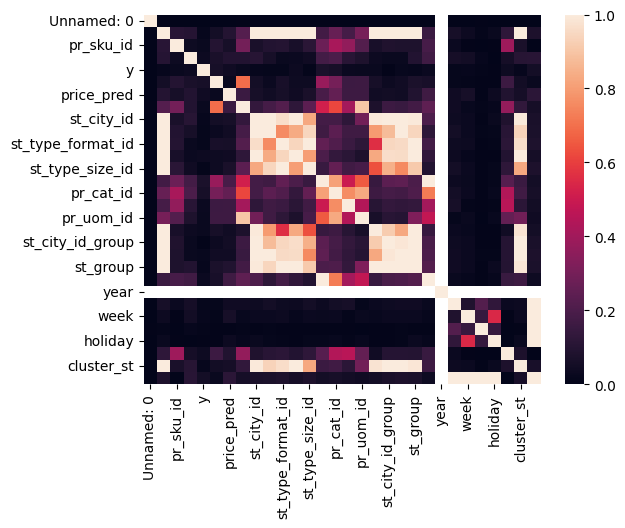

In [20]:
sns.heatmap(df.phik_matrix())